<a id="2"></a>

# **2. Imports**
Will import necessary packages for data manupulation e.g numpy, data viewing e.g pandas, plotting e.g matplot library, seaborn and additional packages for text processing and numerical computations

In [1]:
#packages for general processing of data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
# set plot style
sns.set()

#packages for natural language processing
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
lemmatizer = WordNetLemmatizer()
import string

#Packages for machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#packages for checking the performance of the models used
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#packages for web scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re


#packages for balancing our data
from sklearn.utils import resample
import imblearn
from imblearn.over_sampling import SMOTE

We are ready with all the packages required for the data processing. The next step is to import the available data for analysis.
>For the purpose of this project, we have been provided with the following data:
>1. df_train.csv :- This data wil be using for training our model
>2. df_test.csv :- This data will test our model for the purpose of kaggle competition
>3. Sample_submission.csv :- Contain a sample submission on kaggle

In [2]:
df_train = pd.read_csv('./train.csv') # This code imports the train data 
df_test = pd.read_csv('./test.csv') # This code import the test data
sample = pd.read_csv('./sample_submission.csv') #This code imports a sample submission data

For good practice, will not modify the given data but we will instead make a copy of both the training and testing data as follows

In [3]:
df = df_train.copy() # This code makes a copy of the training data
test_data = df_test.copy() # This code makes a copy of the test data

# EXPLORATORY DATA ANALYSIS

We will try to dig deep into both the training and testing data to ensure that our data meets the following:
>1. Correctly formatted
>2. Have the correct data types
>3. No null values
>4. Correctly distributed i.e. normally distributed
>5. No coliniarity for classification problem or no multicollinearity for regression problem

Exploratory data analysis is the key that will lead us to feature engineering and choosing the right machine learning algorithm for our data

### a). Checking the content of the training data

In [4]:
#We start by checking the features available in our training data
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
#we also check the column names as follows
print(df.columns.to_list())

['sentiment', 'message', 'tweetid']


In both cases, we see three columns i.e. sentiment (the y variable based on the predict), message and tweetid(the unique identification of each entry)

### b). Checking the content of the testing data

In [6]:
#lets confirm that the test data also have the same content as the train data
test_data.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [7]:
#lets see the columns for the test data
print(test_data.columns.to_list())

['message', 'tweetid']


It makes sense for the test data not having the sentiment column i.e. the y  variable. This shows we are good to go

### c). Checking the distribution of the y variable

In [8]:
#This code will check how the sentiments are distributed 
df.groupby(by='sentiment').count() # checking the distribution of the sentiment

,message,tweetid
sentiment,,
-1,1296,1296
0,2353,2353
1,8530,8530
2,3640,3640


Lets plot the result above in a pie chart to show the percentage of the unique y observations

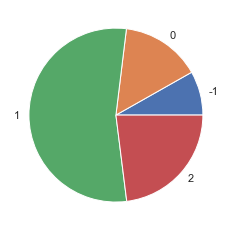

In [9]:
m = df.groupby(by='sentiment').count() #this code group the train data by sentiment and make a count of each group
values = m['message'].to_list() # values contains the total counts of each group
m_index = m.index.to_list() # m_index contains the label of each group

#the code below will plot a pie chart showing the percentage of each sentiment
plt.pie(values, labels=m_index)
plt.show()

It is not enough to just visualize this on a piechart but rather try to visualize how far each is one group from another. We therefore use a bar graph to achieve our goal

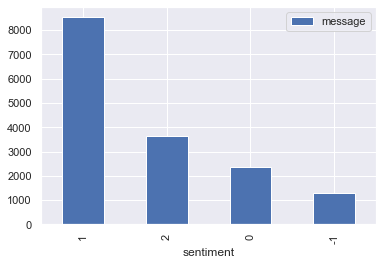

In [10]:
#this code will plot the distribution of the sentiments on a bar graph
sum_df = df[['sentiment', 'message']].groupby('sentiment').count()

# Plot message by sentiment
sum_df.sort_values('message', ascending=False).plot(kind='bar')
plt.show()

### d). Checking for null values and the data types

In [11]:
#for this purpose, we will combine both the test and train data set
#we drop the sentiment feature for compatablity reasons
df_all = pd.concat([df.drop('sentiment', axis = 1),test_data]) 


#we then check for null values in both data sets
df_all.isnull().sum()

message    0
tweetid    0
dtype: int64

In [12]:
#this code will check the data type of each feature
print('Data types available are')
print(df_all.dtypes.to_list())

print('')

print('Below is the table info')
print(df_all.info())

Data types available are
[dtype('O'), dtype('int64')]

Below is the table info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26365 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  26365 non-null  object
 1   tweetid  26365 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 617.9+ KB
None


### e). Diving deep into our features

For us to know how to tweek this data for best prediction results. We seek to understand the trends within our features. We will check for the following:
> 1. Punctuation 
> 2. Stopwords 
> 3. Single words being used in singular and plural form.
> 4. Check for links

In [13]:
# We will create a random set of data for our analysis. We will majorly focus on the message feature

import random # random will help fetch random index

#we dont want to interfere with the index of our dataset here, we therefore make a copy for our analysis
eda_df = df_all.copy()

#for our plan to work as expected, we will need to rearange the index of our data set
eda_df = eda_df.reset_index().drop('index', axis = 1)

n = len(eda_df.index.to_list()) #n represent the total number of observations in the whole data set

#we make a list of 10 randomly chosen index from our data
i = 0
check_list = []
while i<10:
    j = random.randint(0,n)
    check_list.append(j)
    i = i+1  

#we make a list of random data from the 10 randomly chosen index
random_data = []
for i in check_list:
    random_data.append(eda_df.message[i].split())
    
plain_random_data = []
for i in random_data:
    for k in i:
        plain_random_data.append(k)
        
#the study data is now ready for use and are stored in a variable called plain_random_data. Lets dive in

In [14]:
# we then check the subset of the available data and see what operations we can perform
plain_random_data[:5]

['RT', '@SteveNash:', 'Toby', 'is', 'the']

 1. Checking for punctuations

In [15]:
import string

#we split the punctuations from the string
punctuations = []
l = string.punctuation
for i in l:
    punctuations.append(i)

#create a bag of letters for analysis
bag_of_letters = []
for i in plain_random_data:
    for k in i:
        bag_of_letters.append(k)

#we will create a list of all available punctuations for futher use as well
total_punctuations = []
for i in bag_of_letters:
    if i in punctuations:
        total_punctuations.append(i)

Total punctuations = 87/1131 letters
This accounts to  7.6923076923076925%


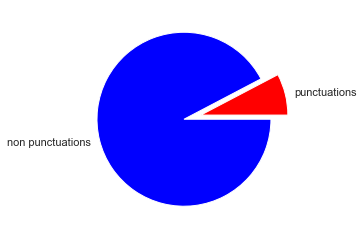

In [16]:
#lets check if we manage to catch some punctuations in our sample

print(f'Total punctuations = {len(total_punctuations)}/{len(bag_of_letters)} letters')
print(f'This accounts to  {(len(total_punctuations)/len(bag_of_letters))*100}%')

percentage_punctuations = np.round((len(total_punctuations)/len(bag_of_letters))*100, 2)

plt.pie([percentage_punctuations, 100-percentage_punctuations], 
        labels=['punctuations','non punctuations'], explode = [0,0.2], colors = ['red','blue'])
plt.show()

2. checking for stop words

In [17]:
#first we import stopwords and define stopwords_list
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

#we store all available stopwords in our data in a list called available_stopwords
available_stopwords = []
for i in plain_random_data:
    if i in stopwords_list:
        available_stopwords.append(i)

Total stopwords = 41/172 words
This accounts to  23.837209302325583%


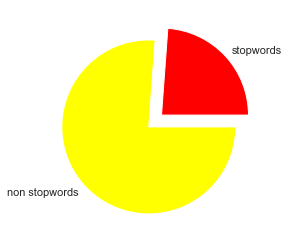

In [18]:
##lets check if we manage to catch some stopwords in our sample

print(f'Total stopwords = {len(available_stopwords)}/{len(plain_random_data)} words')
print(f'This accounts to  {(len(available_stopwords)/len(plain_random_data))*100}%')

percentage_stopwords = np.round((len(available_stopwords)/len(plain_random_data))*100, 2)

plt.pie([percentage_stopwords, 100-percentage_stopwords], 
        labels=['stopwords','non stopwords'], explode = [0,0.2], colors = ['red','yellow'])
plt.show()

3. Single Words being used in singular and plural form.

In [20]:
#to check for this, we need to know the total number of unique words in our sample and set it to words_unique variable
total_words_unique = len(np.unique((np.array(plain_random_data))))

# we therefore perform stemming and the total number of unique words reduced, then we can know where to stand

#we import the snowballstemmer and set it to english
from nltk import SnowballStemmer
stemmer = SnowballStemmer('english')

#create a list of stemmed sample
new_plain_random_data = []

for i in plain_random_data:
    new_plain_random_data.append(stemmer.stem(i))
    
new_total_words_unique = len(np.unique((np.array(new_plain_random_data))))

Total unique words before steming = 130
Total unique words after steming = 128
This accounts to  1.538461538461533 % of the total words


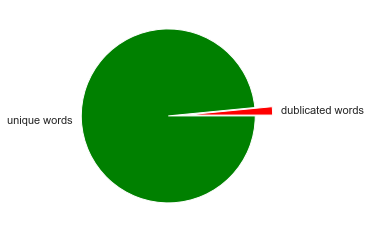

In [21]:
#lets confirm if something happened
print(f'Total unique words before steming = {total_words_unique}')
print(f'Total unique words after steming = {new_total_words_unique}')
print(f'This accounts to  {100-((new_total_words_unique/total_words_unique)*100)} % of the total words')

#plot a pie chart to show the results
percentage_dublicate_words = np.round(100-((new_total_words_unique/total_words_unique)*100),2)
plt.pie([percentage_dublicate_words, 100-percentage_dublicate_words], 
        labels=['dublicated words','unique words'], explode = [0,0.2], colors = ['red','green'])
plt.show()

4. checking for links

In [22]:
#This code will loop through the sample to get all links  and store them in a variable total_links
total_links = []
for i in plain_random_data:
    if i[:4] in 'http':
        total_links.append(i)

Total available links = 10 links
This account to  5.813953488372093 % of the total words


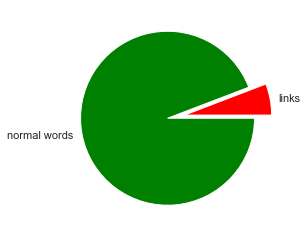

In [23]:
#Lets check if we manage to find some links within our sample
print(f'Total available links = {len(total_links)} links')
print(f'This account to  {(len(total_links)/len(plain_random_data))*100} % of the total words')

percentage_links = np.round((len(total_links)/len(plain_random_data))*100,2)

plt.pie([percentage_links, 100-percentage_links], 
        labels=['links','normal words'], explode = [0,0.2], colors = ['red','green'])
plt.show()

5. checking if we can get something from the links

For this purpose, we will try to dig into the available links and check through their title if we can find some information. We will import beautiful soup for the purpose of web scrapping.

In [25]:
for i in plain_random_data:
    if i[:4] in 'http':
        try:
            html = urlopen(i)
        except:
            html = 'url_web'
        soup = BeautifulSoup(html)
        try:
            title = soup.title.text
        except AttributeError:
            title = 'url_web'
        except:
            title = 'url_web'
        print(f'{i} == {title}')      

https://t.co/E9smaQulJv == url_web
https://t.co/1WC520Oieo == url_web
https://t.co/nv8WkcD0a3 == url_web
https://t.co/L1mj6eUwq5 == url_web
https://t.co/LkDehj3tNn == National Geographic Channel
https://t.co/xYnkHd6cQk == url_web
http… == url_web
https://Ã¢â‚¬Â¦ == url_web
https://t.co/M2wfxrfUbl == url_web
https://t.co/MxIAnpvfxG == url_web


### Key take aways from EDA

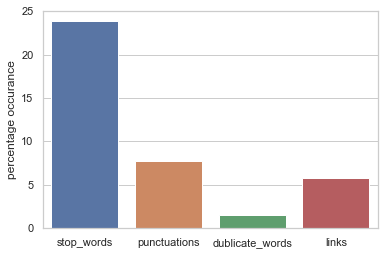

In [26]:
#We plot a graph to show the stats from our sample
percentages = [percentage_stopwords,percentage_punctuations,percentage_dublicate_words,percentage_links]
sns.set_theme(style='whitegrid')
fig = sns.barplot(x = ['stop_words', 'punctuations', 'dublicate_words', 'links'],y = percentages)
fig.set(xlabel ='',ylabel='percentage occurance')
plt.show()

Based on the EXPLORATORY DATA ANALYSIS we have carried out, we have realised the following:
1. The data we have is free from Null values: 
> Most machine learning algorithms such as the random forest classifier, logistic regression, support vector machine etc do not accept data with null values. We, therefore, aim at removing or filling up null values appropriately before feeding our data into any machine learning model.

2. The data is not correctly distributed:
> The total number of responses differ from one y value to another [ -1 has 1296 responses], [0 has 2353 responces], [1 has 8330 responces], [2 has 3640 responces]. This will be a problem for most machine learning algorithms such as logistic regression. For a model to have an equal probability of predicting each given value of y, then the total count of all y responses should be the same during the training time.

3. The data is not correctly formatted:
> Even though there are no null values. The data type of each feature in the training set does not all satisfy the expected data types. The message feature consists of the object data type which will need to be rectified before modelling.

4. There are uninvited visitors in our data:
> stop words and punctuations do impact negatively our model's predictive power. We, therefore, have to remove them in advance before they cause much trouble. 

5. There is some information that can be found in the links.
> Some of these links contain some information i.e. the title talking about climate change. Will need to extract them for our analysis.
